In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import floor
from keras import models
from keras import layers
from keras import optimizers
from scipy.integrate import odeint

# Descenso del gradiente

In [1]:
#derivada parcial de una función:
#g=función
#k es la variable respecto a la que se deriva X=(x1, x2,..., xk,..)
#X es el punto en el que se evalua la derivada
def partial(g, k, X):
    h = 1e-9
    Y = np.copy(X)
    X[k - 1] = X[k - 1] + h
    dp = (g(X) - g(Y)) / h
    return dp

#Regresa el vector gradiente de una función f evaluando en X, tiene una cota para evitar que explote el valor del gradiente
#pero manteniendo la dirección del mismo
def gradcot(f, X, cota):
    grd = []
    for i in np.arange(0, len(X)):
        #aquí definiremos la cota para el gradiente 
        ai = partial(f, i + 1, X)
        if ai<0:
            ai = max(ai, -1*cota)
        else:
            ai = min(ai, cota)
        grd.append(ai)
    return grd

#esta función aplica el descenso del gradiente a una función f, comenzando en un punto X0
#eta=learning rate
#steps=número máximo de iteraciones a realizar
#tolerance=norma del vector gradiente en la que ya es buena idea terminar las iteraciones
def desgrad(f,X0,eta, steps, cota=100, tolerance=10e-8):
    i=0
    while True:
        i=i+1
        X0=X0-eta*np.array(gradcot(f,X0, cota))

        if np.linalg.norm(gradcot(f,X0, cota))<tolerance or i>steps: break
    return X0

#nos arroja X0 donde la función debe tener un mínimo

# Descenso del gradiente aplicado a una regresión lineal
En este caso se ajustó de forma lineal los valores para $H_0$

La pendiente es 69.425330
La ordenada es 60.114713


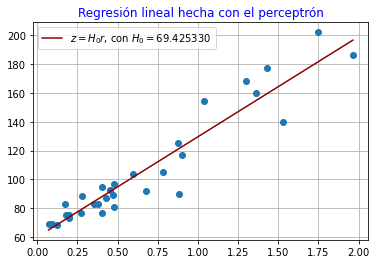

In [6]:
#importamos los datos
file='datosH.txt'
datos=np.loadtxt(file)
redshift=datos[:,0]
v=datos[:,1]
error=datos[:,2]

#agregamos una columna de 1 a x
x=redshift
y=v

x1=[]
for i in x:
    i=np.append(i,1.0)
    x1.append(i)
x1=np.array(x1)


def error(W,x=redshift,y=v):
    s=0
    for i in range(0,len(y)):
        l=0.5*(np.dot(x1[i],W)-y[i])**2
        s=s+l
    return s


m,b=desgrad(error,[1,1],0.01,100)
print("La pendiente es %f"%m)
print("La ordenada es %f"%b)

#Ahora que encontramos los valosres que buscamos graficamos

plt.plot(x,y,'o')
plt.plot(x,m*x+b,color='darkred',label='$z=H_0r$, con $H_0= 69.425330$')
plt.title("Regresión lineal hecha con el perceptrón", color='b')
plt.grid()
plt.legend()

# Definición de las funciones de activación a utilizar


In [8]:
# RELU
def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

#IDENTIDAD
def iden(X):
    return X
def diden(X):
    return 1

#SIGMOIDE
def sigmoid(X):
    return 1/(1+np.exp(-X))
def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))

#TANGENTE HIPORBÓLICA
def tanh(X):
    return np.tanh(X)
def dtanh(X):
    return 1-tanh(X)**2


# Función split para separa un conjunto de datos X,Y
separa un conjunto X,Y en dos pares: $X_{train}$,$Y_{train}$

$X_{val}$,$Y_{val}$

In [9]:
def split(X,Y,porcent): #El porcentaje debe estar dado entre 0 y 1, será el porcentaje que mandará a entrenamiento
    n=floor(porcent*len(X))
    index=random.sample(range(len(X)),n)
    X_learn=[]
    Y_learn=[]
    for i in index:
        X_learn.append(X[i])
        Y_learn.append(Y[i])
    X_val=np.delete(X,index, axis=0)
    Y_val=np.delete(Y,index, axis=0)
    
    X_learn=np.array(X_learn)
    Y_learn=np.array(Y_learn)
    
    return X_learn,Y_learn,X_val,Y_val


# Definición del forward propagation
Este forward es para una red de una sola capa oculta 

In [10]:
#Definimos el forward propagation por si se quiere evaluar un determiado valor después de haber entrenado la red
def forward(X,W1,b1,W2,b2,activation):
    z1=np.dot(X,W1)+b1
    a1=activation(z1)
    z2=np.dot(a1,W2)+b2
    a2=z2
    return a2

# Función de coste

In [11]:
#función de coste:
def error(C):
    m=len(C)
    e=(1/(2*m))*np.linalg.norm(C)**2
    return e

# Red neuronal de una sola capa
X,Y= conjunto de datos
nodos=número de nodos que llevará la capa oculta
batch_size (Este debería decir split_size, pero no lo cambio para evitar errores)
activation=le decimos cuál de las funciones que definimos arriba queremos usar
así como su derivada correspondiente

#### Además de graficarnos el error, nos regresa los parámetros de la red W, b para su uso posterior

In [15]:
def neuralnet(X,Y,nodos,batch_size,learning_rate,epocas,activation,dactivation):
    #Definimos la estructura de la red
    n_entradas=len(X[0])
    n_salidas=len(Y[0])
    
    #definimos los conjuntos de aprendizaje y validación 
    X_learn,Y_learn,X_val,Y_val = split(X,Y,batch_size)
    
    #forward
    W1=np.random.randn(n_entradas,nodos)
    W2=np.random.randn(nodos,n_salidas)
    b1=np.random.randn(nodos)
    b2=np.random.randn(n_salidas)
    
    #z1=np.dot(X_learn,W1)+b1
    #a1=activation(z1)
    #z2=np.dot(a1,W2)+b2
    #a2=z2
    
    #épocas
    errores=[]
    validacion=[]
    for i in range(epocas+1):
        #Forward
        z1=np.dot(X_learn,W1)+b1
        a1=activation(z1)
        z2=np.dot(a1,W2)+b2
        a2=z2
        
        #backpropagation
        delta2 = a2-Y_learn
        delta1 = (delta2).dot(W2.T)*dactivation(z1)
        
        errores.append(error(delta2)) #guardamos el error de cada época

        W2 -= learning_rate * a1.T.dot(delta2)
        b2 -= learning_rate * (delta2).sum(axis=0)

        W1 -= learning_rate * X_learn.T.dot(delta1)
        b1 -= learning_rate * (delta1).sum(axis=0)
        print("Época %d, coste %f" %(int(i),error(delta2)))
        
        #Ahora validamos el modelo
        z1=np.dot(X_val,W1)+b1
        a1=activation(z1)
        z2=np.dot(a1,W2)+b2
        a2=z2
        delta = a2-Y_val
        validacion.append(error(delta))
        
    plt.plot(range(i+1),errores,color='darkcyan',label='Aprendizaje')
    plt.plot(range(i+1),validacion,color='darkred',label='Validación')
    plt.grid()
    plt.legend()
    return W1,b1,W2,b2

# Una red parecida, pero con Keras

In [12]:
nodos=10
split_size=0.8
learning_rate=0.1
epocas=100

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X,Y,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(len(X[0]),),use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(len(Y[0]),use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

NameError: name 'X' is not defined

# Ajuste a la ecuación de Friedmann con ambas redes

In [16]:
#Función a emular
def Hlcdm(z, Om=0.27, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)


X=2.3*np.random.rand(1000,1)
Y=Hlcdm(X, Om=0.27, H0=73.24)

# Con la red trucha

Época 0, coste 11194.180036
Época 1, coste 9035.307692
Época 2, coste 7013.813350
Época 3, coste 5326.052442
Época 4, coste 4028.569609
Época 5, coste 3092.693252
Época 6, coste 2412.337945
Época 7, coste 1937.484829
Época 8, coste 1640.652215
Época 9, coste 1449.680157
Época 10, coste 1320.171438
Época 11, coste 1222.723811
Época 12, coste 1136.488520
Época 13, coste 1045.506094
Época 14, coste 940.039963
Época 15, coste 826.126849
Época 16, coste 723.912445
Época 17, coste 637.635094
Época 18, coste 564.545157
Época 19, coste 503.087934
Época 20, coste 451.359623
Época 21, coste 407.603418
Época 22, coste 370.324874
Época 23, coste 338.294519
Época 24, coste 310.520391
Época 25, coste 286.212761
Época 26, coste 264.748294
Época 27, coste 245.637248
Época 28, coste 228.495159
Época 29, coste 213.019381
Época 30, coste 198.970232
Época 31, coste 186.156280
Época 32, coste 174.423003
Época 33, coste 163.644246
Época 34, coste 153.715707
Época 35, coste 144.550104
Época 36, coste 136.073

Época 376, coste 5.563836
Época 377, coste 5.081524
Época 378, coste 5.515509
Época 379, coste 5.039725
Época 380, coste 5.467880
Época 381, coste 4.998508
Época 382, coste 5.420934
Época 383, coste 4.957862
Época 384, coste 5.374658
Época 385, coste 4.917776
Época 386, coste 5.329038
Época 387, coste 4.878239
Época 388, coste 5.284061
Época 389, coste 4.839240
Época 390, coste 5.239716
Época 391, coste 4.800770
Época 392, coste 5.195988
Época 393, coste 4.762817
Época 394, coste 5.152868
Época 395, coste 4.725372
Época 396, coste 5.110342
Época 397, coste 4.688426
Época 398, coste 5.068400
Época 399, coste 4.651970
Época 400, coste 5.027030
Época 401, coste 4.615994
Época 402, coste 4.986223
Época 403, coste 4.580489
Época 404, coste 4.945967
Época 405, coste 4.545448
Época 406, coste 4.906252
Época 407, coste 4.510862
Época 408, coste 4.867069
Época 409, coste 4.476723
Época 410, coste 4.828408
Época 411, coste 4.443022
Época 412, coste 4.790260
Época 413, coste 4.409753
Época 414, c

Época 745, coste 1.846010
Época 746, coste 1.914196
Época 747, coste 1.838711
Época 748, coste 1.906346
Época 749, coste 1.831459
Época 750, coste 1.898548
Época 751, coste 1.824254
Época 752, coste 1.890804
Época 753, coste 1.817097
Época 754, coste 1.883112
Época 755, coste 1.809986
Época 756, coste 1.875472
Época 757, coste 1.802921
Época 758, coste 1.867884
Época 759, coste 1.795904
Época 760, coste 1.860349
Época 761, coste 1.788933
Época 762, coste 1.852866
Época 763, coste 1.782009
Época 764, coste 1.845435
Época 765, coste 1.775131
Época 766, coste 1.838056
Época 767, coste 1.768300
Época 768, coste 1.830728
Época 769, coste 1.761515
Época 770, coste 1.823453
Época 771, coste 1.754776
Época 772, coste 1.816229
Época 773, coste 1.748084
Época 774, coste 1.809057
Época 775, coste 1.741438
Época 776, coste 1.801936
Época 777, coste 1.734838
Época 778, coste 1.794867
Época 779, coste 1.728285
Época 780, coste 1.787849
Época 781, coste 1.721777
Época 782, coste 1.780882
Época 783, c

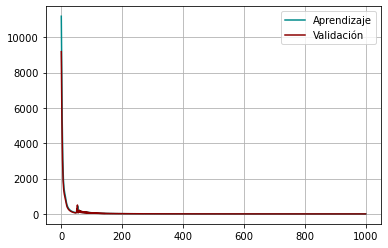

In [17]:
W1,b1,W2,b2=neuralnet(X,Y,10,0.2,0.0001,1000,activation=sigmoid,dactivation=dsigmoid)

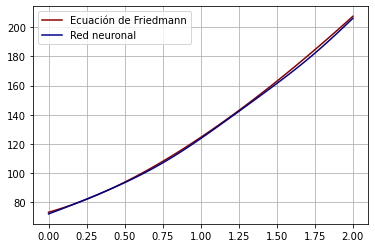

In [19]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkred',label='Ecuación de Friedmann')
plt.plot(z,forward(z,W1,b1,W2,b2,sigmoid),label='Red neuronal',color='darkblue')
plt.legend()
plt.grid()

# Con Keras

Epoch 1/100
200/200 [==============================] - 2s 3ms/step - loss: 10319.0590 - val_loss: 401.5658
Epoch 2/100
200/200 [==============================] - 0s 849us/step - loss: 215.0478 - val_loss: 10.1386
Epoch 3/100
200/200 [==============================] - 0s 834us/step - loss: 20.5661 - val_loss: 3.1266
Epoch 4/100
200/200 [==============================] - 0s 829us/step - loss: 14.6925 - val_loss: 5.3803
Epoch 5/100
200/200 [==============================] - 0s 869us/step - loss: 13.7686 - val_loss: 10.7356
Epoch 6/100
200/200 [==============================] - 0s 844us/step - loss: 13.2174 - val_loss: 2.1954
Epoch 7/100
200/200 [==============================] - 0s 834us/step - loss: 11.0428 - val_loss: 2.5626
Epoch 8/100
200/200 [==============================] - 0s 729us/step - loss: 13.1965 - val_loss: 0.7642
Epoch 9/100
200/200 [==============================] - 0s 688us/step - loss: 10.0245 - val_loss: 2.4917
Epoch 10/100
200/200 [==============================] - 0s

200/200 [==============================] - 0s 779us/step - loss: 3.0372 - val_loss: 6.3489
Epoch 80/100
200/200 [==============================] - 0s 709us/step - loss: 3.4754 - val_loss: 0.6800
Epoch 81/100
200/200 [==============================] - 0s 744us/step - loss: 2.9870 - val_loss: 5.4324
Epoch 82/100
200/200 [==============================] - 0s 764us/step - loss: 2.8141 - val_loss: 1.4870
Epoch 83/100
200/200 [==============================] - 0s 895us/step - loss: 2.8856 - val_loss: 0.4348
Epoch 84/100
200/200 [==============================] - 0s 678us/step - loss: 2.6502 - val_loss: 3.3954
Epoch 85/100
200/200 [==============================] - 0s 643us/step - loss: 2.6136 - val_loss: 3.5560
Epoch 86/100
200/200 [==============================] - 0s 653us/step - loss: 2.8560 - val_loss: 6.8534
Epoch 87/100
200/200 [==============================] - 0s 724us/step - loss: 3.7202 - val_loss: 9.4679
Epoch 88/100
200/200 [==============================] - 0s 869us/step - loss:

Text(0.5, 1.0, 'Error durante el entrenamiento')

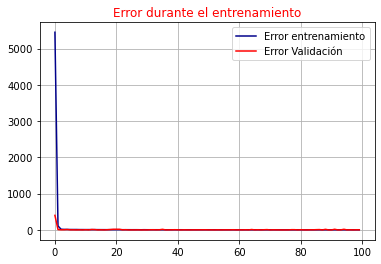

In [20]:
nodos=10
split_size=0.8
learning_rate=0.1
epocas=100

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X,Y,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(len(X[0]),),use_bias=1,activation='sigmoid')
#para la capa de salida usamos Id como activación
salida=layers.Dense(len(Y[0]),use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

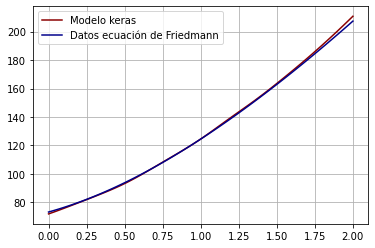

In [21]:
plt.plot(z,model.predict(z),label='Modelo keras',color='darkred')
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkblue',label='Datos ecuación de Friedmann')
#plt.plot(X,Y,'o')
plt.grid()
plt.legend()

# Entrenamiento con ecuaciones diferenciales

#### Sistema de ecuaciones
Resolver:

$\dot \rho_i + 3(1+\gamma)H\rho_i = 0$

$H^2 = \frac{\kappa_0}{3}\sum \rho_i$

Cambiando variables, a:

$\Omega_i = \frac{\kappa_0 }{3H^2} \rho_i$ 

# 1. Transformamos la EDO en una función

In [29]:
def RHS(Omega_i, lna, gamma=0):
    #x, y, z, H = Omega_i
    x, y, z = Omega_i
    pi = 3*x + 4*y
    #return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]
    return [x*(-3 + pi), y*(-4 + pi), z*pi]

def EDO(t,Om,Or):
    #t,Or,Om,Ol=X
    #Or=0.0001
    Ol=1-Or-Om
    H0 = 70.
    y0 = [Om, Or, Ol]
    result = odeint(RHS, y0, t)
    return result

# 2. Gneramos el conjunto de datos 
Con las suficientes convinaciones de $\Omega _i$ como para que el algrtimo aprenda
Vamos a variar 



$O_m \in [0.1, 0.5]$

$O_r \in [0.0001, 0.0010]$

$t \in [0,-12]$



In [30]:
#O_m=np.linspace(0.1,0.5,50)
O_m=np.arange(0.1,0.5,0.01)
#O_r=np.linspace(0.0001,0.0010,50)
O_r=np.arange(0.0001,0.0010,0.00001)
t=np.linspace(0,-12,50)

##### hacemos la combinatoria de estos conjuntos

In [31]:
Y0=[]
#este ciclo llena la lista fijando un Om y pasando todos los Or
for i in O_m:
    for j in O_r:
        Y0.extend(EDO(t,i,j))
Y0=np.array(Y0)

X0=[]
for Om in O_m:
    for Or in O_r:
        for T in t:
            X0.append([T,Om,Or])
X0=np.array(X0)

##### Para este problema se usó una red de dos capas ocultas, con función de activación sigmoide

# nota: No corrí este entrenamiento porque tarda un poco, pero adjunto el modelo con el que trabajé en el artículo y guardé.

De igual manera se puede ejecutar y variar los hiperparámetros para que entrene otra vez

In [ ]:
#Dos paredes ocultas
nodos=50
split_size=0.8
learning_rate=0.001
epocas=150

#Separamos los datos en validación y entrenamiento
X_learn,Y_learn,X_val,Y_val=split(X0,Y0,split_size)

#Armamos el modelo con estructura 'Sequential'
model=models.Sequential()

#la primer capa recibe un numero solamente, usaremos sigmoide como función de activación para la capa oculta
capa1=layers.Dense(nodos, input_shape=(3,),use_bias=1,activation='sigmoid')
capa2=layers.Dense(nodos,use_bias=1,activation='sigmoid')

#para la capa de salida usamos Id como activación
salida=layers.Dense(3,use_bias=1)

#armamos el modelo
model.add(capa1)
model.add(capa2)
model.add(salida)
#Ahora definimos el paso de compilación, con learning rate=0.001
#Función de error cuadrático medio


model.compile(optimizer=optimizers.RMSprop(lr=learning_rate), loss='mse')

#por último traemos los datos de entrenamiento y los procesamos con 'fit()'
history=model.fit(X_learn,Y_learn,validation_data=(X_val, Y_val),batch_size=4,epochs=epocas,shuffle=True)

error=history.history['loss']
exac=history.history['val_loss']
epochs=np.arange(0,len(error))
plt.plot(epochs,error,label='Error entrenamiento',color='darkblue')
plt.plot(epochs,exac,label='Error Validación',color='r')
plt.legend()
plt.grid()
plt.title('Error durante el entrenamiento',color='red')

# Prueba del modelo entrenado

In [36]:
import keras
model = keras.models.load_model('red_Or_Om.h5')

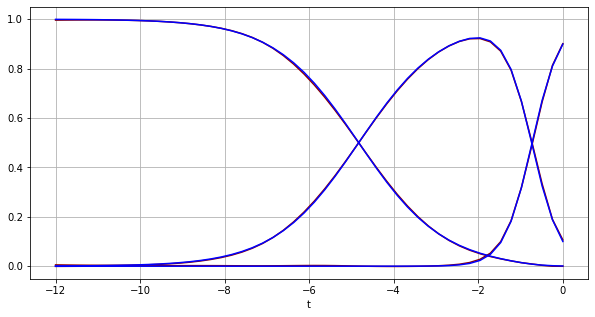

In [39]:
Z=np.linspace(0,-12,50)
dom=[]
dom2=[]
dom3=[]
#Distintas combinaciones de los hiperparámetros, para el modelo keras

for z in Z: dom.append([z,0.1,0.0008]) 
A=model.predict(dom)

for z in Z: dom2.append([z,0.5,0.0009]) 
B=model.predict(dom2)

for z in Z: dom3.append([z,0.3,0.0001]) 
C=model.predict(dom3)

#función real
D=EDO(Z, 0.1,0.0008)

#Comparación entre la real y el modelo
plt.figure(figsize=(10,5))
plt.plot(Z,A,color='darkred')
plt.plot(Z,D,color='blue')

plt.xlabel('t')
plt.grid()
#plt.legend()

##### Distintas combinaciones de los parámetros 

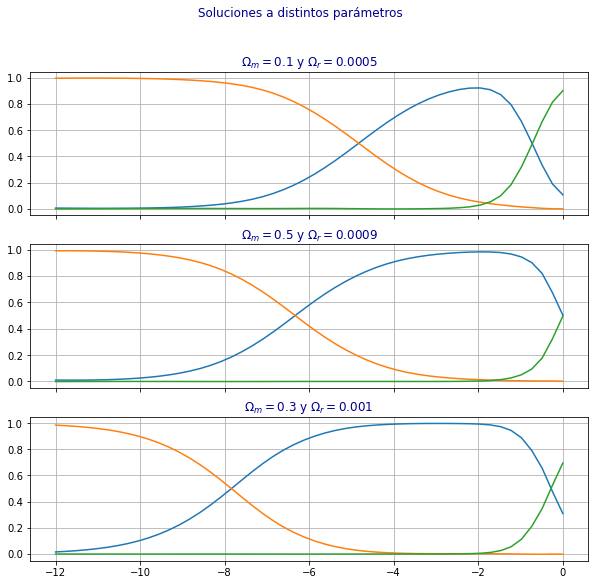

In [40]:
fig, (ax1, ax2,ax3) = plt.subplots(3, sharex=True, figsize=(10,9))
fig.suptitle('Soluciones a distintos parámetros', color='darkblue')
ax1.plot(Z, A)
ax1.grid()
ax1.set_title('$\Omega_m = 0.1$ y $\Omega_r = 0.0005$', color='darkblue')

ax2.plot(Z, B)
ax2.grid()
ax2.set_title('$\Omega_m = 0.5$ y $\Omega_r = 0.0009$', color='darkblue')

ax3.plot(Z, C)
#ax3.plot(Z,D,color='darkred')
ax3.set_title('$\Omega_m = 0.3$ y $\Omega_r = 0.001$', color='darkblue')
ax3.grid()
